# Computer Vision: Teaching Machines to See  


This notebook follows the lesson plan you provided. Each section starts with a short analogy-driven explanation and then code cells you can run.

> Tip: If you don't have an image handy, the notebook will generate synthetic demo images automatically so every section runs.

## Setup
We import libraries, print versions, and define small helpers for visualization.

In [ ]:
import cv2, numpy as np, matplotlib.pyplot as plt, math, os, sys
from pathlib import Path

print("OpenCV:", cv2.__version__)
print("Python:", sys.version.split()[0])

def show(img, title=None, cmap=None):
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_disp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_disp = img
    plt.figure(figsize=(5,5))
    plt.imshow(img_disp, cmap=cmap)
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

OpenCV: 4.12.0
Python: 3.12.11


## Basics: How Machines "See"
### Opening: What is Computer Vision? (Detective Analogy)
Computer vision is like training a very systematic detective to examine photos: look carefully, notice details (features), recognize patterns, and make decisions.

### Section 1 — The CV Pipeline (Restaurant Kitchen Analogy)
1. **Image Acquisition** = getting ingredients delivered (camera frames)  
2. **Pre-processing** = washing & cutting (denoise, normalize)  
3. **Feature Extraction** = identifying key ingredients (edges, corners, textures)  
4. **Decision Making** = following the recipe (classification/detection)  
Below we start with acquisition using a file path (or we auto-generate demo images).

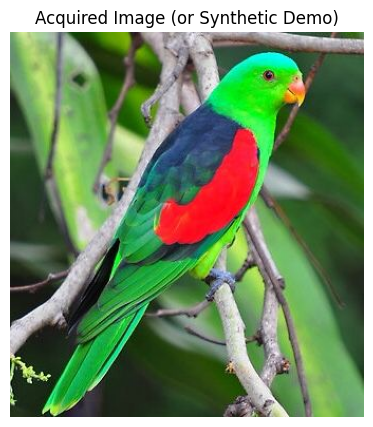

In [ ]:
IMAGE_PATH = 'Parrot.jpg'  # e.g., 'data/scene.jpg'

def synthetic_scene(size=512):
    img = np.full((size,size,3), 255, np.uint8)
    cv2.rectangle(img, (40,40), (200,180), (60,60,200), -1)
    cv2.circle(img, (360,130), 60, (200,80,80), -1)
    cv2.line(img, (50,300), (450,480), (50,120,50), 6)
    step = 32
    for i in range(8, 8+6):
        for j in range(8, 8+6):
            if (i+j) % 2 == 0:
                cv2.rectangle(img, (i*step, j*step), ((i+1)*step, (j+1)*step), (30,30,30), -1)
    cv2.putText(img, 'OpenCV', (250, 300), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (20,20,20), 3, cv2.LINE_AA)
    return img

if IMAGE_PATH and Path(IMAGE_PATH).exists():
    img = cv2.imread(IMAGE_PATH)
    assert img is not None, "Failed to read image."
else:
    img = synthetic_scene()
show(img, "Acquired Image (or Synthetic Demo)")

## Section 2 — Image Processing Fundamentals (Coloring Book Analogy)
- **Grayscale**: black & white coloring book (0–255)  
- **Color**: three stacked books (R, G, B)

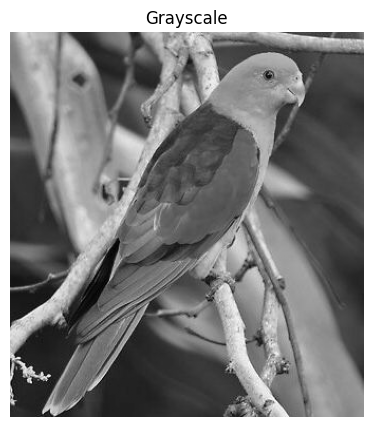

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show(gray, "Grayscale", cmap='gray')

### Blurring — "Wrong Prescription Glasses"
- **Gaussian**: smooth natural blur  
- **Median**: robust to salt & pepper noise  
- **Bilateral**: smooth while preserving edges

In [ ]:
gauss = cv2.GaussianBlur(gray, (5,5), 0)
median = cv2.medianBlur(gray, 5)
bilat = cv2.bilateralFilter(gray, 9, 75, 75)

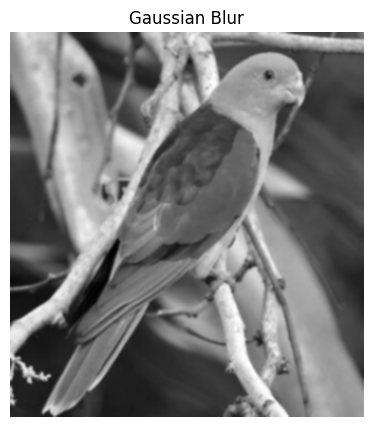

In [ ]:
show(gauss, "Gaussian Blur", cmap='gray')

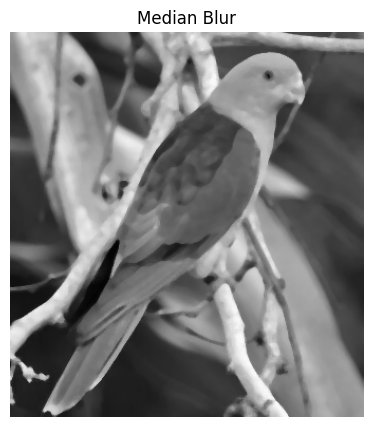

In [ ]:
show(median, "Median Blur", cmap='gray')

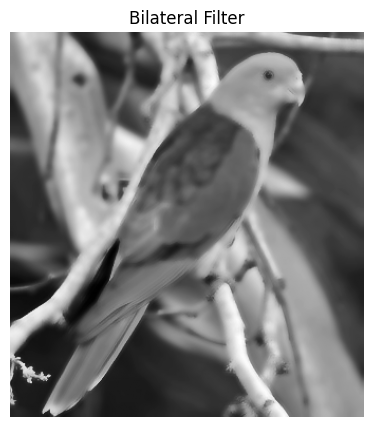

In [ ]:
show(bilat, "Bilateral Filter", cmap='gray')

### Edge Detection — "Tracing Outlines"
We use **Canny** which performs denoising, gradient detection, non-maximum suppression, and hysteresis thresholding.

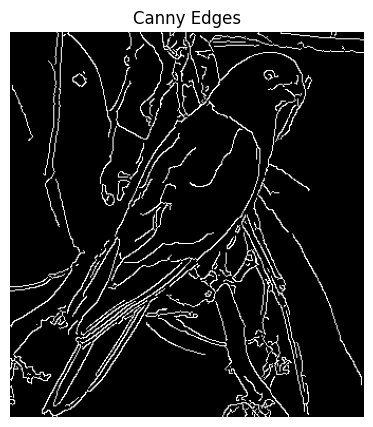

In [ ]:
edges = cv2.Canny(gauss, 50, 150)
show(edges, "Canny Edges", cmap='gray')

### Thresholding — "Stark Black & White"
Simple global threshold and **adaptive** (locally tuned) threshold.

In [ ]:
_, th_global = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
th_adapt_mean = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, 11, 2)
th_adapt_gauss = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 11, 2)

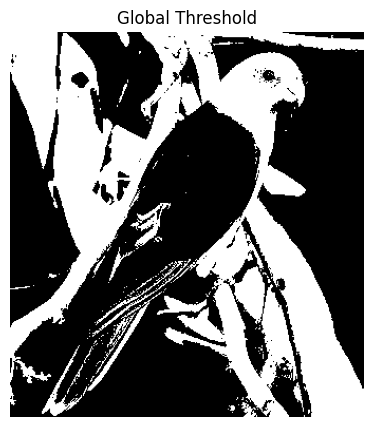

In [ ]:
show(th_global, "Global Threshold", cmap='gray')

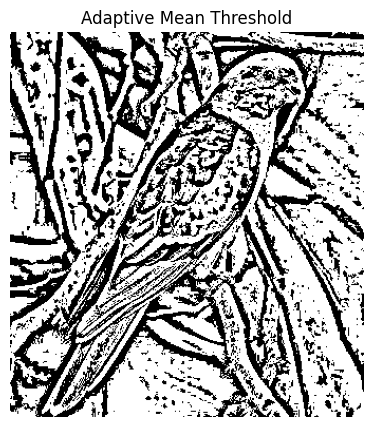

In [ ]:
show(th_adapt_mean, "Adaptive Mean Threshold", cmap='gray')

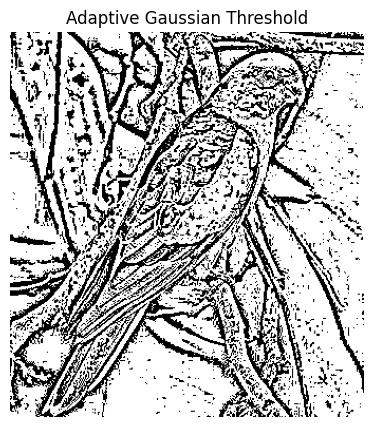

In [ ]:
show(th_adapt_gauss, "Adaptive Gaussian Threshold", cmap='gray')

## Section 3 — Feature Detection (Landmark Recognition Analogy)
Corners & keypoints are like landmarks on a city map.

### Harris Corner Detection — "Building Corners"

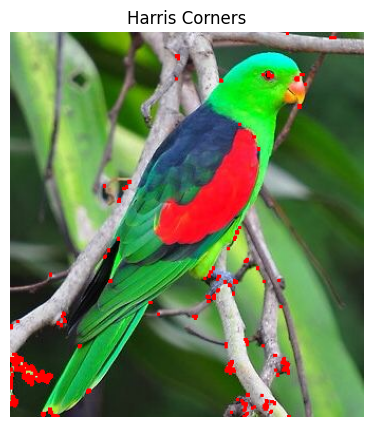

In [ ]:
harris_in = np.float32(gray)
H = cv2.cornerHarris(harris_in, 2, 3, 0.04)
H = cv2.dilate(H, None)
img_harris = img.copy()
img_harris[H > 0.01 * H.max()] = (0,0,255)
show(img_harris, "Harris Corners")

### Shi–Tomasi "Good Features to Track"

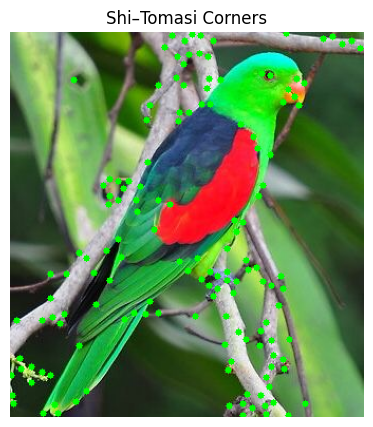

In [ ]:
shi_img = img.copy()
corners = cv2.goodFeaturesToTrack(gray, maxCorners=150, qualityLevel=0.01, minDistance=8)
if corners is not None:
    for c in np.int32(corners).reshape(-1,2):
        cv2.circle(shi_img, tuple(c), 3, (0,255,0), -1)
show(shi_img, "Shi–Tomasi Corners")

### SIFT — "Ultimate Landmark Detector" (falls back to ORB if needed)

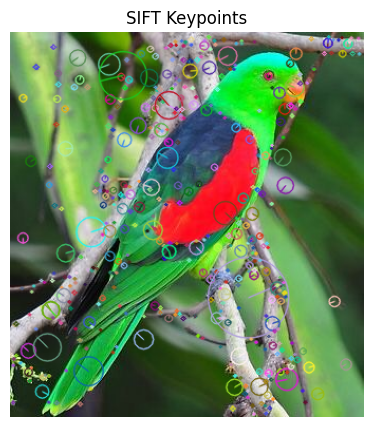

Detected keypoints: 521 | Descriptor shape: (521, 128)


In [ ]:
def detect_features(img_gray, prefer='SIFT'):
    try:
        if prefer == 'SIFT' and hasattr(cv2, 'SIFT_create'):
            f = cv2.SIFT_create()
            name = 'SIFT'
        else:
            raise AttributeError
    except Exception:
        f = cv2.ORB_create(nfeatures=1000)
        name = 'ORB (fallback)'
    kp, des = f.detectAndCompute(img_gray, None)
    return kp, des, name

kp, des, method_name = detect_features(gray, 'SIFT')
draw = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show(draw, f"{method_name} Keypoints")
print(f"Detected keypoints: {len(kp)} | Descriptor shape: {None if des is None else des.shape}")

## Advanced Applications & Real-World Magic
### Section 4 — Feature Matching (Dating App Analogy)
We create a second image by transforming the first, then match features using **Brute Force** and **FLANN**, with **Lowe's ratio test**.

Matches: 521 | Good after ratio: 277


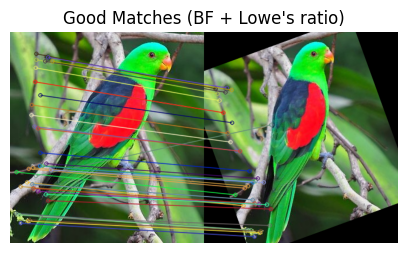

In [ ]:
h, w = gray.shape[:2]
M = cv2.getRotationMatrix2D((w/2, h/2), 20, 0.9)
img2 = cv2.warpAffine(img, M, (w, h))
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

kp1, des1, name1 = detect_features(gray, 'SIFT')
kp2, des2, name2 = detect_features(gray2, 'SIFT')

norm = cv2.NORM_L2 if name1.startswith('SIFT') and des1 is not None else cv2.NORM_HAMMING
bf = cv2.BFMatcher(norm)
matches = bf.knnMatch(des1, des2, k=2)

good = []
for m,n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

print(f"Matches: {len(matches)} | Good after ratio: {len(good)}")
matched_img = cv2.drawMatches(img, kp1, img2, kp2, good[:40], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
show(matched_img, "Good Matches (BF + Lowe's ratio)")

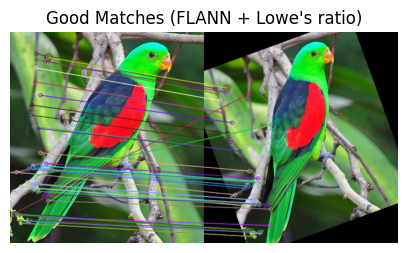

In [ ]:
# FLANN demo for SIFT-like descriptors
if name1.startswith('SIFT') and des1 is not None and des1.dtype != np.uint8:
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    flann_matches = flann.knnMatch(des1, des2, k=2)
    flann_good = [m for m,n in flann_matches if m.distance < 0.75*n.distance]
    flann_img = cv2.drawMatches(img, kp1, img2, kp2, flann_good[:40], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    show(flann_img, "Good Matches (FLANN + Lowe's ratio)")
else:
    print("FLANN demo skipped (requires float descriptors like SIFT).")